In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#1 langkah pertama mengimport data, menampilkan 5 data awal dan 5 data akhir
import pandas as pd
df = pd.read_csv("Data.csv")
print(df.head())
print(df.tail())


   Tahun  nonseasional
0   1961       19273.0
1   1962       19462.0
2   1963       23331.0
3   1964       24263.0
4   1965       22665.0
    Tahun  nonseasional
56   2017       44274.3
57   2018       46810.9
58   2019       44401.9
59   2020       47715.3
60   2021       55688.5


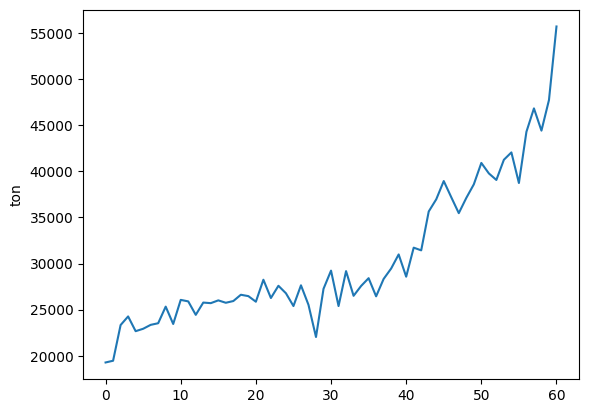

In [4]:
#2 membuat time series plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(df['nonseasional'])
plt.ylabel("ton")
plt.savefig('data plot.png')

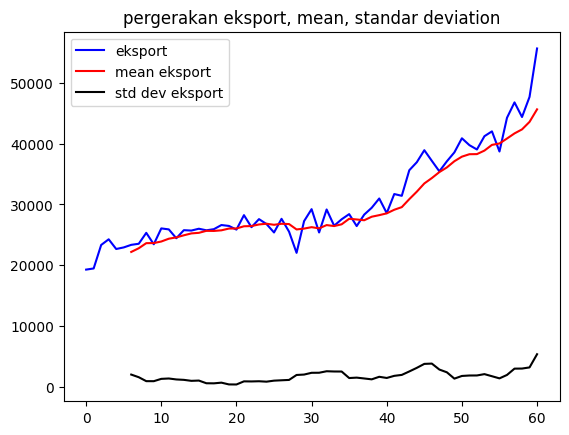

In [5]:
#3 membuat garis rata-rata dan standar error
saham_mean = df['nonseasional'].rolling(7).mean()
saham_std = df['nonseasional'].rolling(7).std()
plt.plot(df['nonseasional'],color="blue", label = "eksport")
plt.plot(saham_mean,color="red", label = "mean eksport")
plt.plot(saham_std,color = "black", label = "std dev eksport")
plt.title("pergerakan eksport, mean, standar deviation")
plt.legend(loc="best")
plt.savefig('rata-rata std deviasi.png')

In [6]:
#4 menganalisa stasioneritas data

from statsmodels.tsa.stattools import adfuller
adft = adfuller(df['nonseasional'],autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0   2.621735              Test Statistics
1   0.999079                      p-value
2   2.000000             No. of lags used
3  58.000000  Number of observations used
4  -3.548494          critical value (1%)
5  -2.912837          critical value (5%)
6  -2.594129         critical value (10%)


In [7]:
#copy data untuk seasionalnya
data = df.copy()
print(data.tail())

    Tahun  nonseasional
56   2017       44274.3
57   2018       46810.9
58   2019       44401.9
59   2020       47715.3
60   2021       55688.5


         Values                       Metric
0 -7.895560e+00              Test Statistics
1  4.320463e-12                      p-value
2  1.000000e+00             No. of lags used
3  5.800000e+01  Number of observations used
4 -3.548494e+00          critical value (1%)
5 -2.912837e+00          critical value (5%)
6 -2.594129e+00         critical value (10%)


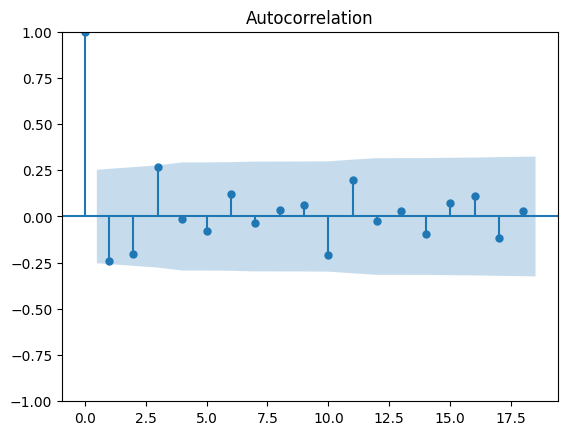

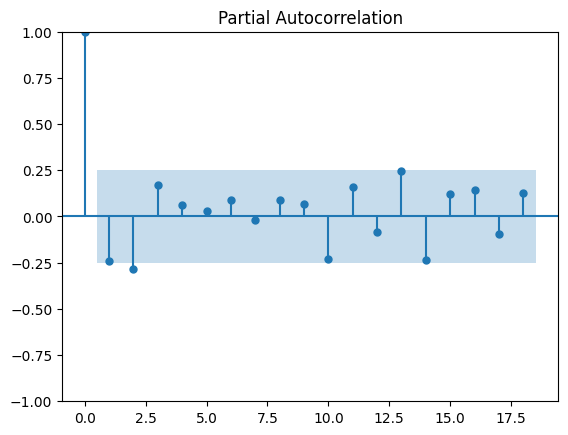

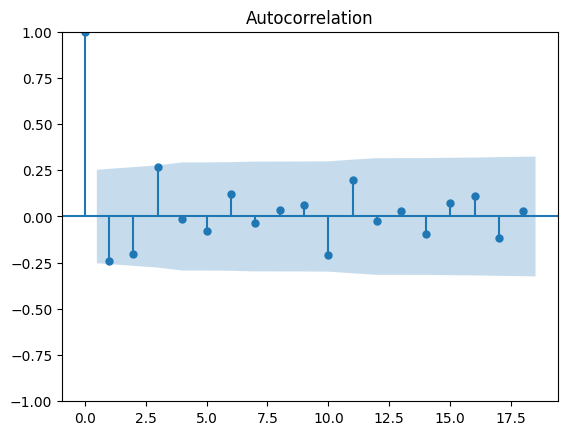

In [9]:
#data['export'] = np.log(df['nonseasional'])
data['export'] = data['nonseasional'].diff()
data = data.drop(data.index[0])

adft = adfuller(data['export'],autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)
plot_pacf(data['export'])
plot_acf(data['export'])

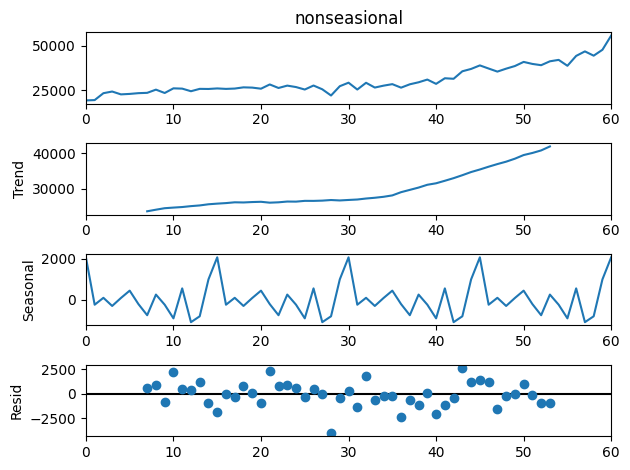

In [10]:
#6 melihat komponen trend dan seasional
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['nonseasional'],model='additive', period=15)
decompose.plot()
plt.savefig('dekomposisi.png', dpi=100)
plt.show()


trend = pd.DataFrame(decompose.trend)
file_name = 'trend.xlsx'
# saving the excel
trend.to_excel(file_name)
trend = pd.DataFrame(decompose.seasonal)
file_name = 'seasonal.xlsx'
# saving the excel
trend.to_excel(file_name)
trend = pd.DataFrame(decompose.resid)
file_name = 'residu.xlsx'
# saving the excel
trend.to_excel(file_name)
trend = pd.DataFrame(decompose.observed)
file_name = 'observed.xlsx'
# saving the excel
trend.to_excel(file_name)



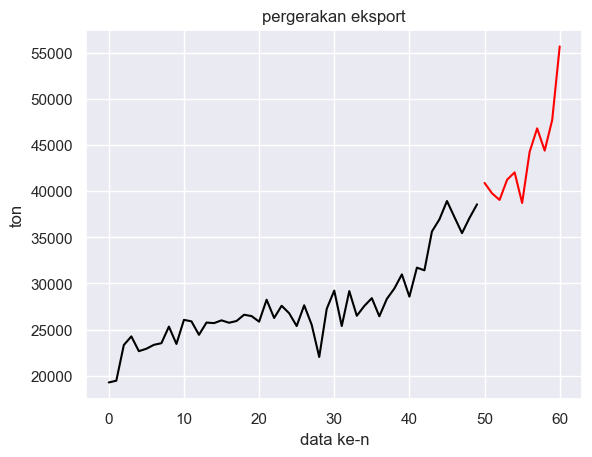

In [12]:
#7 plot data forecasting
df['Tahun'] = df.index
train = df[df['Tahun'] < pd.to_numeric(50)]
train['train'] = train['nonseasional']
del train['Tahun']
del train['nonseasional']
test = df[df['Tahun'] >= pd.to_numeric(50)]
del test['Tahun']
test['test'] = test['nonseasional']
del test['nonseasional']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("pergerakan eksport")
plt.ylabel("ton")
plt.xlabel('data ke-n')
sns.set()
plt.show()

In [26]:
#8 mendapatkan model ARIMA
from pmdarima.arima import auto_arima
target = df['nonseasional']
target_train = target

model = auto_arima(target [:50], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(target [:50])
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
print(forecast)

#save hasil kedalam excel untuk proses selanjutnya
forecast = pd.DataFrame(forecast)
# determining the name of the file
file_name = 'forecast.xlsx'
forecast.to_excel(file_name)
# saving the excel



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=889.612, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=887.884, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=886.231, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=886.625, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=887.762, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=888.144, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=888.728, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=891.009, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=887.507, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.409 seconds
      Prediction
50  38840.024857
51  39329.670156
52  39776.460094
53  40231.318648
54  40684.658080
55  41138.283524
56  41591.855120
57  42045.436854
58  42499.016679
59  42952.596864
60  43406.176981


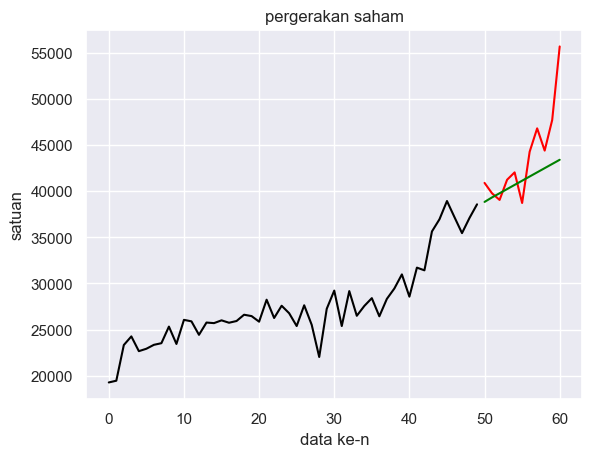

In [27]:
df['Tahun'] = df.index
train = df[df['Tahun'] < pd.to_numeric(50)]
train['train'] = train['nonseasional']
del train['Tahun']
del train['nonseasional']
test = df[df['Tahun'] >= pd.to_numeric(50)]
del test['Tahun']
test['test'] = test['nonseasional']
del test['nonseasional']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast ['Prediction'], color = "green")
plt.title("pergerakan saham")
plt.ylabel("satuan")
plt.xlabel('data ke-n')
sns.set()
plt.savefig('forecast.png', dpi=100)
plt.show()

In [14]:
from pmdarima.arima import auto_arima

target = df['nonseasional']
target_train = target


best_model = auto_arima(target, trace=True, error_action='ignore', suppress_warnings=True)
best_model_fit = best_model.fit(target)

print(best_model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1106.201, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1104.109, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1103.533, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1103.885, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1106.094, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1105.941, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1105.563, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1107.146, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1107.072, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.337 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -548.767
Date:                Sun, 29 Jan 2023   AIC      

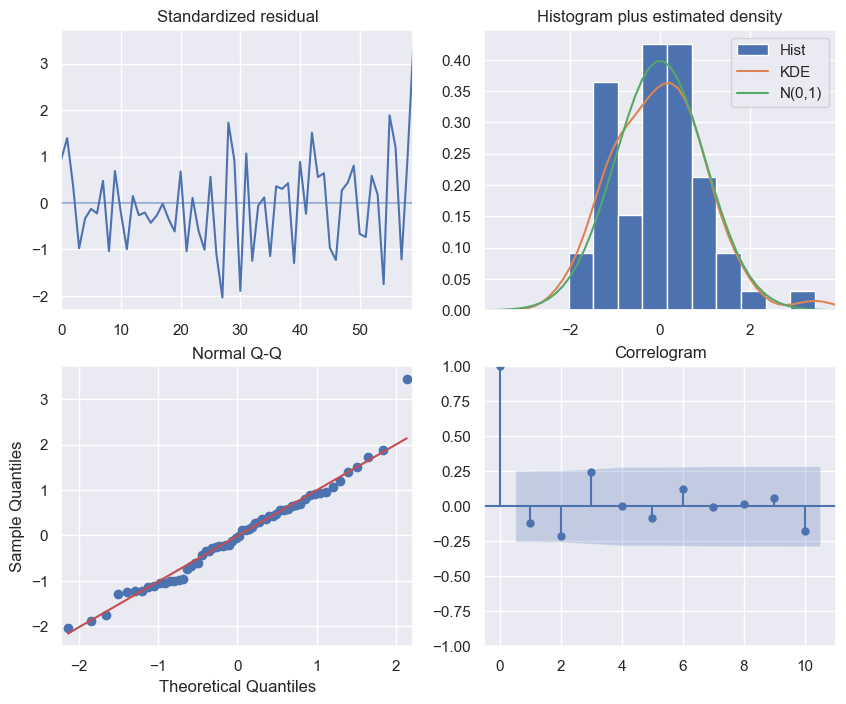

In [15]:
best_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('Cek residual.png', dpi=300)

In [17]:
data['arima_model'] = best_model.fittedvalues
forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 10)
forecast = data['arima_model'].append(forecast)

In [18]:
#save hasil kedalam excel untuk proses selanjutnya
forecast2 = pd.DataFrame(forecast)
# determining the name of the file
file_name = 'forecast2.xlsx'
forecast.to_excel(file_name)
# saving the excel

